In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from model import layer, loss
from model.loss import Loss
from model.layer import Model

In [2]:

def split_batch(data, target, batch_size):
    for i in range(0, len(data), batch_size):
        if i + batch_size < len(data):
            yield data[i:i + batch_size], target[i:i + batch_size]
        else:
            yield data[i:], target[i:]


def train_step(data, target, model: Model, loss_fn: Loss, learning_rate):
    pred = model(data)
    loss = loss_fn(pred, target)
    grad = loss_fn.backward()
    model.backward(grad)
    model.update(learning_rate=learning_rate)
    return loss


def test_step(data, target, model: Model, loss_fn: Loss):
    pred = model(data)
    loss = loss_fn(pred, target)
    return loss

In [3]:
data_df = pd.read_csv('data/ionosphere_data.csv', header=None)

data_df['is_good'] = data_df[34].apply(lambda x: 1 if x == 'g' else 0)
data_df = data_df.drop(34, axis=1)

data_df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,is_good
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,0,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,...,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307,1
347,1,0,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,...,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,1
348,1,0,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,...,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577,1
349,1,0,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,...,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,1


In [4]:
dataset = np.array(data_df)
np.random.default_rng().shuffle(dataset)

train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)

train_feature = dataset[:train_size, :-1]
test_feature = dataset[train_size:, :-1]
train_target = dataset[:train_size, -1:]
test_target = dataset[train_size:, -1:]

In [5]:
INPUT_FEATURES = train_feature.shape[1]

model = Model([
    layer.Linear(INPUT_FEATURES, 8),
    layer.Sigmoid(),
    layer.Linear(8, 2),
    layer.Sigmoid(),
    layer.Linear(2, 1),
    layer.Sigmoid(),
])

bce = loss.BinaryCrossEntropy()

In [6]:

import os

os.makedirs(os.path.join('images', 'classification'), exist_ok=True)


def plot_latent_2d(model, feature, target, epoch):
    model(feature)
    latent = model.layers[-2].inputs
    latent_good = latent[target[:, 0] == 1]
    latent_bad = latent[target[:, 0] == 0]
    plt.clf()
    plt.scatter(latent_good[:, 0], latent_good[:, 1], c='b', label='good')
    plt.scatter(latent_bad[:, 0], latent_bad[:, 1], c='r', label='bad')
    plt.legend()
    plt.title(f'Latent space at epoch {epoch}')
    plt.savefig(os.path.join('images', 'classification',
                             f'latent_{epoch}_2d.png'),
                bbox_inches='tight')


def plot_latent_3d(model, feature, target, epoch):
    model(feature)
    latent = model.layers[-2].inputs
    latent_good = latent[target[:, 0] == 1]
    latent_bad = latent[target[:, 0] == 0]
    plt.clf()
    ax = plt.subplot(projection='3d')
    ax.scatter(latent_good[:, 0],
               latent_good[:, 1],
               latent_good[:, 2],
               c='b',
               label='good')
    ax.scatter(latent_bad[:, 0],
               latent_bad[:, 1],
               latent_bad[:, 2],
               c='r',
               label='bad')
    ax.legend()
    plt.title(f'Latent space at epoch {epoch}')
    plt.savefig(os.path.join('images', 'classification',
                             f'latent_{epoch}_3d.png'),
                bbox_inches='tight')

Epoch 999:
train loss 0.21154031925447664, test loss 0.3506942667398736
train acc 0.9357142857142857, test acc 0.8732394366197183
Epoch 1999:
train loss 0.1029068605407516, test loss 0.2616454846075007
train acc 0.975, test acc 0.9295774647887324
Epoch 2999:
train loss 0.048283655640839945, test loss 0.2689747055917037
train acc 0.9892857142857143, test acc 0.9014084507042254
Epoch 3999:
train loss 0.0287752304419458, test loss 0.28073331901432125
train acc 0.9928571428571429, test acc 0.9154929577464789
Epoch 4999:
train loss 0.017888979671626025, test loss 0.29509078832420593
train acc 0.9964285714285714, test acc 0.9154929577464789


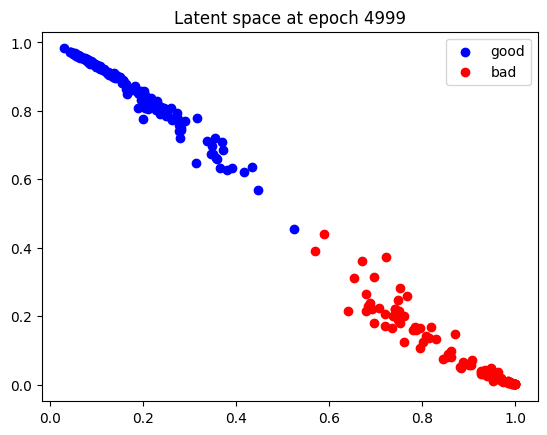

In [7]:
EPOCHES = 5000
BATCH_SIZE = 64
LEARNING_RATE = 0.03

train_accs, test_accs = [], []
train_losses, test_losses = [], []
for epoch in range(EPOCHES):

    train_iter_accs, test_iter_accs = [], []
    train_iter_losses, test_iter_losses = [], []
    for x, y in split_batch(train_feature, train_target, BATCH_SIZE):
        train_loss = train_step(x, y, model, bce, learning_rate=LEARNING_RATE)

        outputs = model(x)
        outputs[outputs > 0.5] = 1
        outputs[outputs <= 0.5] = 0
        train_iter_accs.append(np.sum(outputs == y))
        train_iter_losses.append(train_loss * len(x))
    train_accs.append(np.sum(train_iter_accs) / len(train_feature))
    train_losses.append(np.sum(train_iter_losses) / len(train_feature))

    for x, y in split_batch(test_feature, test_target, BATCH_SIZE):
        test_loss = test_step(x, y, model, bce)

        outputs = model(x)
        outputs[outputs > 0.5] = 1
        outputs[outputs <= 0.5] = 0
        test_iter_accs.append(np.sum(outputs == y))
        test_iter_losses.append(test_loss * len(x))
    test_accs.append(np.sum(test_iter_accs) / len(test_feature))
    test_losses.append(np.sum(test_iter_losses) / len(test_feature))

    if (epoch + 1) == 10 or (epoch + 1) == EPOCHES:
        plot_latent_2d(model, train_feature, train_target, epoch)

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch}:\n'
              f'train loss {train_losses[-1]}, test loss {test_losses[-1]}\n'
              f'train acc {train_accs[-1]}, test acc {test_accs[-1]}')

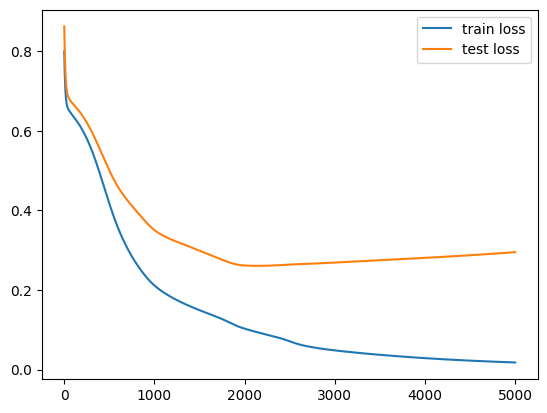

In [8]:

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.savefig(os.path.join('images', 'classification', 'loss.png'),
            bbox_inches='tight')

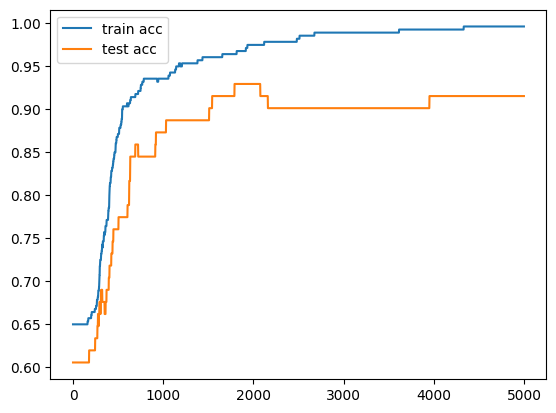

In [9]:
plt.plot(train_accs, label='train acc')
plt.plot(test_accs, label='test acc')
plt.legend()
plt.savefig(os.path.join('images', 'classification', 'acc.png'),
            bbox_inches='tight')

Epoch 999:
train loss 0.42441354587331515, test loss 0.4805385984551801
train acc 0.8607142857142858, test acc 0.8309859154929577
Epoch 1999:
train loss 0.17539999669224782, test loss 0.35146826608560594
train acc 0.95, test acc 0.8873239436619719
Epoch 2999:
train loss 0.09971097140266805, test loss 0.319414734395582
train acc 0.9714285714285714, test acc 0.9014084507042254
Epoch 3999:
train loss 0.06742568689282587, test loss 0.29459582594701655
train acc 0.9857142857142858, test acc 0.9154929577464789
Epoch 4999:
train loss 0.048917010604157395, test loss 0.2717508976925536
train acc 0.9892857142857143, test acc 0.9014084507042254


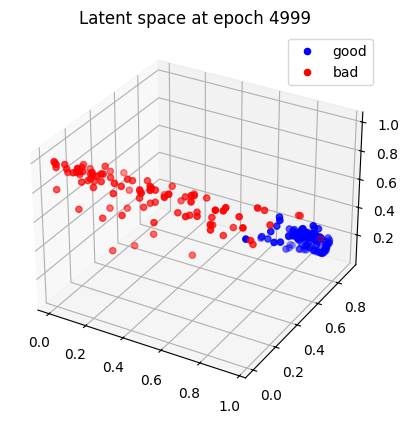

In [10]:
model = Model([
    layer.Linear(INPUT_FEATURES, 8),
    layer.Sigmoid(),
    layer.Linear(8, 3),
    layer.Sigmoid(),
    layer.Linear(3, 1),
    layer.Sigmoid(),
])

train_accs, test_accs = [], []
train_losses, test_losses = [], []
for epoch in range(EPOCHES):
    train_iter_accs, test_iter_accs = [], []
    train_iter_losses, test_iter_losses = [], []
    for x, y in split_batch(train_feature, train_target, BATCH_SIZE):
        train_loss = train_step(x, y, model, bce, learning_rate=LEARNING_RATE)

        outputs = model(x)
        outputs[outputs > 0.5] = 1
        outputs[outputs <= 0.5] = 0
        train_iter_accs.append(np.sum(outputs == y))
        train_iter_losses.append(train_loss * len(x))
    train_accs.append(np.sum(train_iter_accs) / len(train_feature))
    train_losses.append(np.sum(train_iter_losses) / len(train_feature))

    for x, y in split_batch(test_feature, test_target, BATCH_SIZE):
        test_loss = test_step(x, y, model, bce)

        outputs = model(x)
        outputs[outputs > 0.5] = 1
        outputs[outputs <= 0.5] = 0
        test_iter_accs.append(np.sum(outputs == y))
        test_iter_losses.append(test_loss * len(x))
    test_accs.append(np.sum(test_iter_accs) / len(test_feature))
    test_losses.append(np.sum(test_iter_losses) / len(test_feature))

    if (epoch + 1) == 10 or (epoch + 1) == EPOCHES:
        plot_latent_3d(model, train_feature, train_target, epoch)

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch}:\n'
              f'train loss {train_losses[-1]}, test loss {test_losses[-1]}\n'
              f'train acc {train_accs[-1]}, test acc {test_accs[-1]}')

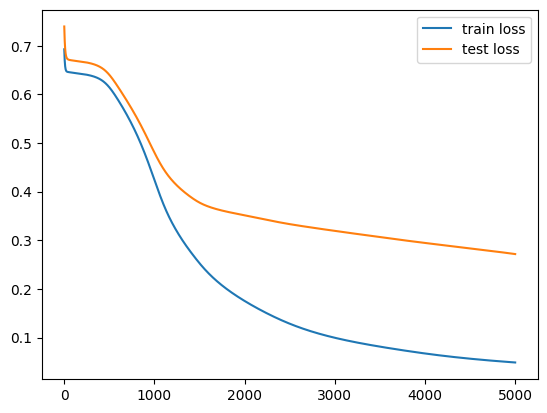

In [11]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

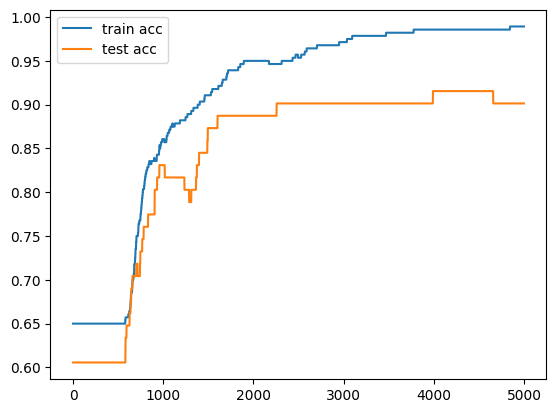

In [12]:
plt.plot(train_accs, label='train acc')
plt.plot(test_accs, label='test acc')
plt.legend()